In [20]:
from torchvision.datasets import FakeData
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim

from diffusers.models import UNet2DModel

from accelerate import Accelerator


## Data Preprocessing

### Fake Data

In [2]:
# Reuse the same transformations
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5]),
])

# Create 100 random fake RGB images at 256x256
smoke_ds = FakeData(
    size=100,
    image_size=(3, 256, 256),
    transform=transform,
    random_offset=0, # seed
)

# Wrap in a loader
smoke_loader = DataLoader(smoke_ds, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


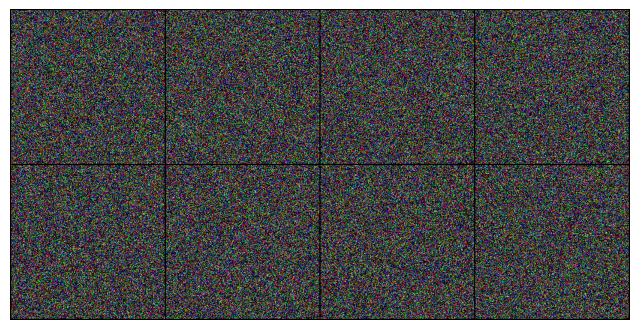

tensor([7, 2, 7, 8, 0, 4, 4, 8])


In [3]:
import torchvision

images,labels = next(iter(smoke_loader))

grid = torchvision.utils.make_grid(images, nrow=4, padding=2)

# plot
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
print(labels)

In [23]:
# load dataloader
dataloader = smoke_loader # temporary

## Models

In [ ]:
# initilize the generators
checkpoint="google/ddpm-celebahq-256" # 128 for smaller image input size
G = UNet2DModel.from_pretrained(checkpoint, use_safetensors=False)
F = UNet2DModel.from_pretrained(checkpoint, use_safetensors=False)

In [12]:
# Freeze encoder of model so that model can learn "aging" during the first epoch
for name, param in G.named_parameters():
    if (
        name.startswith("conv_in") or
        name.startswith("time_proj") or
        name.startswith("time_embedding") or
        name.startswith("down_blocks") or
        name.startswith("mid_block")
    ):
        param.requires_grad = False
        

for name, param in F.named_parameters():
    if (
        name.startswith("conv_in") or
        name.startswith("time_proj") or
        name.startswith("time_embedding") or
        name.startswith("down_blocks") or
        name.startswith("mid_block")
    ):
        param.requires_grad = False

# sanity check
print("Trainable param in G:")
for name, param in G.named_parameters():
    if not param.requires_grad:
        print(" ", name)

Trainable param in G:
  conv_in.weight
  conv_in.bias
  time_embedding.linear_1.weight
  time_embedding.linear_1.bias
  time_embedding.linear_2.weight
  time_embedding.linear_2.bias
  down_blocks.0.resnets.0.norm1.weight
  down_blocks.0.resnets.0.norm1.bias
  down_blocks.0.resnets.0.conv1.weight
  down_blocks.0.resnets.0.conv1.bias
  down_blocks.0.resnets.0.time_emb_proj.weight
  down_blocks.0.resnets.0.time_emb_proj.bias
  down_blocks.0.resnets.0.norm2.weight
  down_blocks.0.resnets.0.norm2.bias
  down_blocks.0.resnets.0.conv2.weight
  down_blocks.0.resnets.0.conv2.bias
  down_blocks.0.resnets.1.norm1.weight
  down_blocks.0.resnets.1.norm1.bias
  down_blocks.0.resnets.1.conv1.weight
  down_blocks.0.resnets.1.conv1.bias
  down_blocks.0.resnets.1.time_emb_proj.weight
  down_blocks.0.resnets.1.time_emb_proj.bias
  down_blocks.0.resnets.1.norm2.weight
  down_blocks.0.resnets.1.norm2.bias
  down_blocks.0.resnets.1.conv2.weight
  down_blocks.0.resnets.1.conv2.bias
  down_blocks.0.downsample

In [ ]:
G


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [16]:
# PatchGAN 70x70
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super().__init__()
        layers = [
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1),
            nn.LeakyReLU(0.2)
        ]
        nf = ndf
        for i in range(3):
            stride = 2 if i < 2 else 1
            layers += [
                nn.Conv2d(nf, nf*2, 4, stride, 1),
                nn.InstanceNorm2d(nf*2),
                nn.LeakyReLU(0.2)
            ]
            nf *= 2
        layers += [nn.Conv2d(nf, 1, 4, 1, 1)]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [18]:
model = PatchDiscriminator()
x = torch.randn(1, 3, 256, 256)
out = model(x)
print(out.shape)

torch.Size([1, 1, 30, 30])


In [19]:
DX = PatchDiscriminator()
DY = PatchDiscriminator()

DX

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
# initlize the discriminator
DX = PatchDiscriminator()
DY = PatchDiscriminator()

# initilize the optimizers
LR = 2e-4
opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5,0.999))
opt_F = optim.Adam(F.parameters(), lr=LR, betas=(0.5,0.999))
opt_DX = optim.Adam(DX.parameters(), lr=LR, betas=(0.5,0.999))
opt_DY = optim.Adam(DY.parameters(), lr=LR, betas=(0.5,0.999))

# prepare (uses hf accelerate to move models o right device and wraps in optimzers too)
accelerator = Accelerator(mixed_precision="fp16")

G, F, DX, DY, opt_G, opt_F, opt_DX, opt_DY = accelerator.prepare(
    G, F, DX, DY, opt_G, opt_F, opt_DX, opt_DY, dataloader
    # learning rate schedulers
) # everything lives on the GPU with automatic CPU fallback, distributed data parallel, mixed precision

## Train Logic

In [1]:
# loss functions and scalers
bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()
lambda_cyc = 10.0
lambda_id = 5.0

NameError: name 'nn' is not defined

In [ ]:
def perform_train_step(
    G, F, # generator models
    DX, DY, # discriminator models
    real_data,
    bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
    opt_G, opt_F, # generator optimizers
    opt_DX, opt_DY # discriminator optimizers
):
    x, y = real_data
    # Generate fakes and reconstrucitons
    fake_x = F(y)
    fake_y = G(x)
    rec_x = F(fake_y)
    rec_y = G(fake_x)
    
    # ------ Update Discriminators ------
    # DX: real young vs fake young
    opt_DX.zero_grad(set_to_none=True) 
    real_logits = DX(x)
    real_targets = torch.ones_like(real_logits)
    real_loss = bce(real_logits, real_targets)
    
    fake_logits = DX(fake_x.detach())
    fake_targets = torch.zeros_like(fake_logits)
    fake_loss = bce(fake_logits, fake_targets)

    # DY loss + backprop + step
    loss_DX = 0.5 * (real_loss + fake_loss)
    accelerator.backward(loss_DX)
    opt_DX.step()
    # DY: real old vs fake old
    opt_DY.zero_grad(set_to_none=True) 
    real_logits = DY(y)
    real_targets = torch.ones_like(real_logits)
    real_loss = bce(real_logits, real_targets)
    
    fake_logits = DY(fake_y.detach())
    fake_targets = torch.zeros_like(fake_logits)
    fake_loss = bce(fake_logits, fake_targets)

    # DY loss + backprop + step
    loss_DY = 0.5 * (real_loss + fake_loss) # average loss to prevent discriminator learning "too quickly" compread to generators.
    accelerator.backward(loss_DY)
    opt_DY.step()
    
    # ------ Update Generators ------
    opt_G.zero_grad(set_to_none=True)
    opt_F.zero_grad(set_to_none=True)
    # Loss 1: adversarial terms
    fake_test_logits = DX(fake_x) # fake x logits
    loss_f_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
    
    fake_test_logits = DY(fake_y) # fake y logits
    loss_g_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
    # Loss 2: cycle terms
    loss_cyc = lambda_cyc * (l1(rec_x, x) + l1(rec_y, y))
    # Loss 3: identity terms
    loss_id = lambda_id * (l1(G(y), y) + l1(F(x), x))
    # Total loss
    loss_total = loss_g_adv + loss_f_adv + loss_cyc + loss_id

    # Backprop + step
    accelerator.backward(loss_total)
    opt_G.step()
    opt_F.step()
    
    return loss_DX, loss_DY, loss_g_adv, loss_f_adv, loss_cyc, loss_id, loss_total
    

In [ ]:
PRINT_STATS_AFTER_BATCH = 200

def perform_epoch(
    dataloader,
    G, F,
    DX, DY,
    bce, l1, lambda_cyc, lambda_id,
    opt_G, opt_F, # generator optimizers
    opt_DX, opt_DY, # discriminator optimizers
    epoch,
):
    """ Perform a single epoch."""
    for batch_no, real_data in enumerate(dataloader):
        # Perform training step
        loss_DX, loss_DY, loss_g_adv, loss_f_adv, loss_cyc, loss_id, loss_total = perform_train_step(
            G, F, # generator models
            DX, DY, # discriminator models
            real_data,
            bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
            opt_G, opt_F, # generator optimizers
            opt_DX, opt_DY # discriminator optimizers
        )
        # Print statistics and generate iamge after every n-th batch
        if batch_no % PRINT_STATS_AFTER_BATCH == 0:
            print(f"loss_DX: {loss_DX} | loss_DY: {loss_DY} | loss_total: {loss_total} | \
                loss_g_adv: {loss_g_adv} | loss_f_adv: {loss_f_adv} | \
                loss_cyc: {loss_cyc} | loss_id: {loss_id}")
            # generate_image(G, epoch, batch_no)
        # Save models on epoch completion
        # save_models(G, F, DX, DY, lambda_cyc, lambda_id, epoch)
        # Clear memory after every epoch
        torch.cuda.empty_cache()

In [ ]:
NUM_EPOCHS = 1

def main():
    """ Train the CycleGan """
    # Speed ups
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
    torch.backends.cudnn.benchmark = True
    
    # Make directory for unique run
    # make_directory_for_run()
    # Set fixed random number seed if wanted
    # set_seed()
    # Get prepared dataset
    # dataloader = prepare_dataset()
    # Initialize models
    # = initalize_models()
    # Initialize loss and optimizers
    # = initialize_loss()
    # = initialize_optimizers()
    # Train the model
    for epoch in range(NUM_EPOCHS):
        print(f"\nStaring epoch {epoch}...")
        perform_epoch(
            dataloader,
            G, F,
            DX, DY,
            bce, l1, lambda_cyc, lambda_id,
            opt_G, opt_F,
            opt_DX, opt_DY,
            epoch,
        )
    # Finished
    print(f"Finished run")

In [ ]:
if __name__ == "__main__":
    main()